In [2]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

# PPG preprocessing

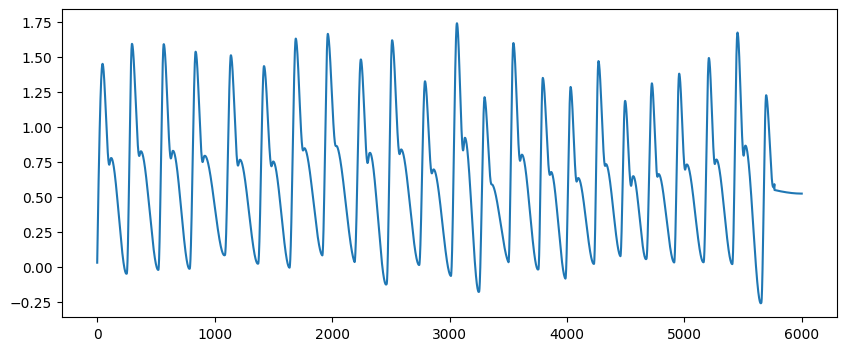

In [16]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})
plt.figure(figsize=(10,4))
plt.plot(data)

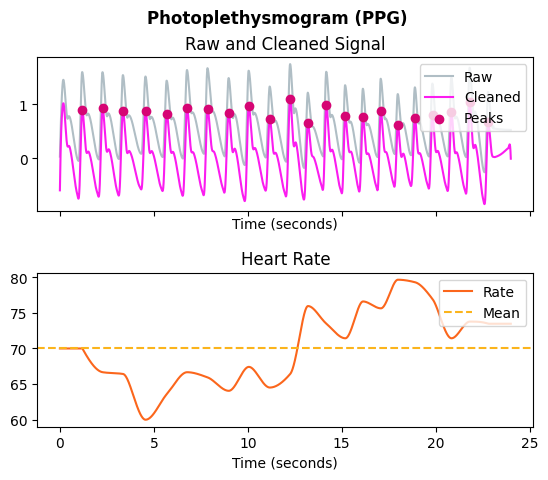

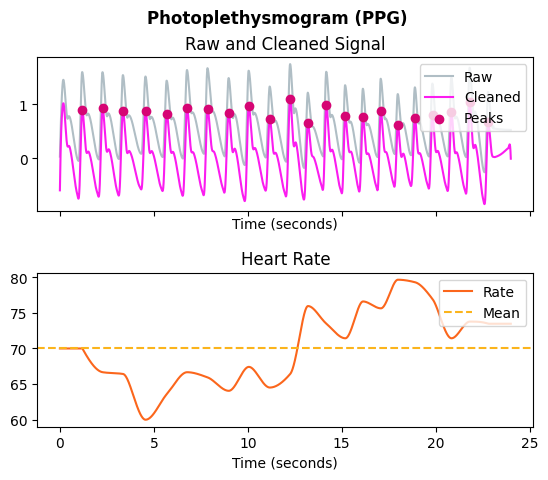

In [17]:
# Process it
signals, info = nk.ppg_process(data, sampling_rate=300)

# Visualize the processing
nk.ppg_plot(signals, sampling_rate=250)

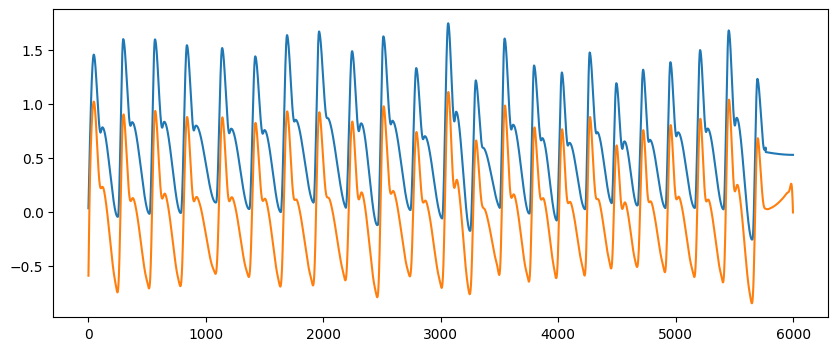

In [18]:
ppg_elgendi_clean = nk.ppg_clean(ppg, method='elgendi', sampling_rate=300)
ppg_nabian_clean = nk.ppg_clean(ppg, method='nabian2018')

signals_filtered = pd.DataFrame({'PPG_Raw' : ppg,
                        'PPG_Elgendi' : ppg_elgendi_clean,})
plt.figure(figsize=(10,4))
plt.plot(signals_filtered)


In [19]:
data = nk.data("bio_resting_5min_100hz")

event_time = []
for i in range(10):
    event_time.append(int((i/10)*len(data)))
print(event_time)

data_samp = data["PPG"]
df, info = nk.ppg_process(data["PPG"], sampling_rate=300)

# Visualize the processing
#nk.ppg_plot(df, sampling_rate=300)

epochs = nk.epochs_create(df, events=event_time, sampling_rate=100,
                          epochs_end=150)


features = nk.ppg_intervalrelated(epochs)
features_event = nk.ppg_eventrelated(epochs)
features.dropna(axis='columns')
features_event.dropna(axis='columns')
print(features)
print(features_event)

[0, 3000, 6000, 9000, 12000, 15000, 18000, 21000, 24000, 27000]
   Label  PPG_Rate_Mean  HRV_MeanNN   HRV_SDNN  HRV_SDANN1  HRV_SDNNI1  \
1      1      99.058035  184.712500  62.345342         NaN         NaN   
2      2      95.316011  192.363636  64.160963         NaN         NaN   
3      3      91.439622  201.081081  90.875914         NaN         NaN   
4      4      91.844634  201.513514  89.874226         NaN         NaN   
5      5      94.345175  195.644737  89.911913         NaN         NaN   
6      6      97.354045  189.088608  82.915958         NaN         NaN   
7      7      80.215646  175.092308  46.057954         NaN         NaN   
8      8      64.271303  169.557692  41.515607         NaN         NaN   
9      9      43.453322  168.342857  41.453690         NaN         NaN   
10    10      21.325073  171.823529  41.438562         NaN         NaN   

    HRV_SDANN2  HRV_SDNNI2  HRV_SDANN5  HRV_SDNNI5  ...  HRV_SampEn  \
1          NaN         NaN         NaN         NaN

Text(0, 0.5, '$EDA$')

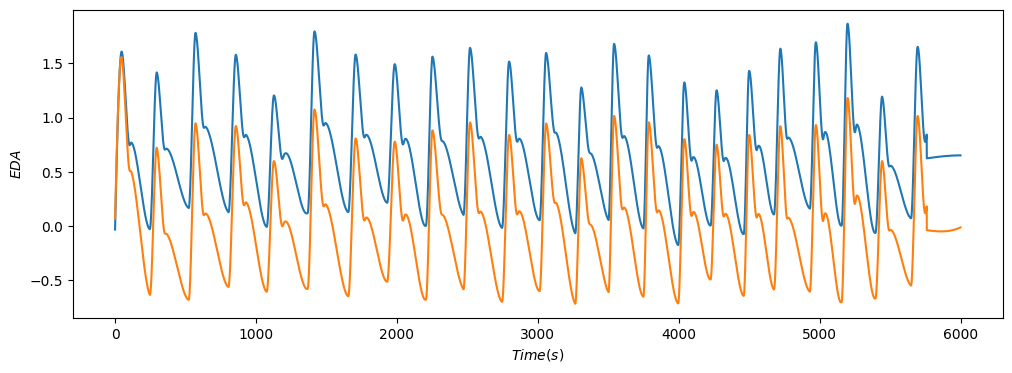

In [20]:
ppg = nk.ppg_simulate(duration=20, sampling_rate= 300, heart_rate=70)
data = pd.DataFrame({"PPG": ppg,})

############ lowpass filtering
# Parameters 
order = 5
frequency = 0.3
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).


# Filtering
b, a = scipy.signal.butter(order, frequency, btype='high')
eda_lp = scipy.signal.filtfilt(b, a, ppg)

# plot
plt.figure(figsize=(12,4))
plt.plot(data)
plt.plot(eda_lp)
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

# BVP data

In [259]:
def bvp_feat(data):
    #event_time = []
    features_bvp = None

    #for i in range(samples):
    #    event_time.append(int((i/samples)*len(data)))

    df, info = nk.ppg_process(data, sampling_rate=200)

    # Visualize the processing
    #nk.ppg_plot(df, sampling_rate=fs)

    epochs = nk.epochs_create(df, events=[1],
                             epochs_start=-0.1, epochs_end=1.9)

    features_event = nk.ppg_eventrelated(epochs)
    #features = nk.ppg_intervalrelated(epochs)
    features = nk.ppg_analyze(df, sampling_rate=200)

    features_event.reset_index(drop=True, inplace=True)

    features_bvp = pd.concat([features_event, features], axis = 1)
    features_bvp = features_bvp.dropna(axis='columns')
    return features_bvp

In [260]:
def bvp_prep(data):
    data = data.dropna(axis='columns')
    features = data
    features.replace([np.inf, -np.inf], np.nan, inplace=True)
    features = features.dropna(axis='columns')
    features.drop(columns=features.columns[:2], axis=1,  inplace=True)
    features = features.reset_index()
    return features

In [23]:
# Dataset reading
class read_data_of_one_subject:
            """Read data from WESAD dataset"""
            def __init__(self, path, subject):
                self.keys = ['label', 'subject', 'signal']
                self.signal_keys = ['wrist', 'chest']
                self.chest_sensor_keys = ['ACC', 'ECG', 'EDA', 'EMG', 'Resp', 'Temp']
                self.wrist_sensor_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
                #os.chdir(path)
                #os.chdir(subject)
                with open(path + subject +'/'+subject + '.pkl', 'rb') as file:
                    data = pickle.load(file, encoding='latin1')
                self.data = data

            def get_labels(self):
                return self.data[self.keys[0]]

            def get_wrist_data(self):
                """"""
                #label = self.data[self.keys[0]]
                #assert subject == self.data[self.keys[1]]
                signal = self.data[self.keys[2]]
                wrist_data = signal[self.signal_keys[0]]
                #wrist_ACC = wrist_data[self.wrist_sensor_keys[0]]
                #wrist_ECG = wrist_data[self.wrist_sensor_keys[1]]
                return wrist_data

            def get_chest_data(self):
                """"""
                signal = self.data[self.keys[2]]
                chest_data = signal[self.signal_keys[1]]
                return chest_data

In [24]:
# Set up empty dataframes for the features
fs = 700 # sampling frequency
y = []
features_bvp_df = None

data_set_path= "C:/Users/JackC/Documents/EPO4/WESAD/WESAD/" # Folder path
#data_set_path= "C:/Users/riche/Downloads/WESAD/WESAD/" # Folder path
#data_set_path = "C:/Users/Adnane/Downloads/WESAD/WESAD/"

for i in range(16): # 15 subjects
    subject = 'S'+str(i+2) # Cycle through S2 to S17
    print(subject)
    if subject != 'S12': # Skip S12, because it does not exist
        # Object instantiation
        obj_data = {}

        # Accessing class attributes and method through objects
        obj_data[subject] = read_data_of_one_subject(data_set_path, subject)

        wrist_data_dict = obj_data[subject].get_wrist_data()
        wrist_dict_length = {key: len(value) for key, value in wrist_data_dict.items()}

        # Get labels
        labels = obj_data[subject].get_labels()

        for label in range(1,5): # for every state of stress
            
            baseline = np.asarray([idx for idx,val in enumerate(labels) if val == label])
            baseline = baseline * 64 // fs
            bvp_base=wrist_data_dict['BVP'][baseline,0] # Select the BVP data

            duration = 25

            # Multiple smaller samples per signal
            samples = 10 # specify amount of samples
            
            for j in range(samples):

                # adding the labels to y
                if label==3 or label==4: # if amusement or medidation, classify as non-stress
                    y.append(1)
                else:
                    y.append(label)

                #bvp = bvp_base[int(len(bvp_base)* (j/samples)) : int(len(bvp_base)* ((j+1)/samples))]
                # choosing a random begin point for smaller sample
                begin = random.randint(0, min(len(bvp_base),len(bvp_base))- duration * fs)

                bvp = bvp_base[begin: begin + duration*fs]
                features_bvp = bvp_feat(bvp, samples, fs)
                features_bvp_df = pd.concat([features_bvp_df, features_bvp], axis = 0)

S2


KeyboardInterrupt: 

# PPG sample data

In [ ]:
import ipynb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import neurokit2 as nk
import random
import pyhrv
from scipy.signal import find_peaks

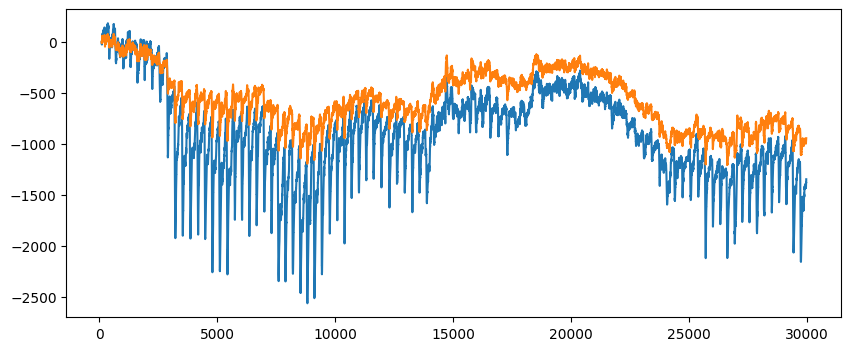

In [26]:
PPG_data = pd.read_csv('C:/Users/JackC/Documents/EPO4-C2/Testday_1/Daan-rest_1.csv')
fs = 400

red_data = PPG_data.iloc[100:,[3]]
ir_data = PPG_data.iloc[100:,[4]]

plt.figure(figsize=(10,4))
plt.plot(red_data-red_data.iloc[0,0])
plt.plot(ir_data-ir_data.iloc[0,0])

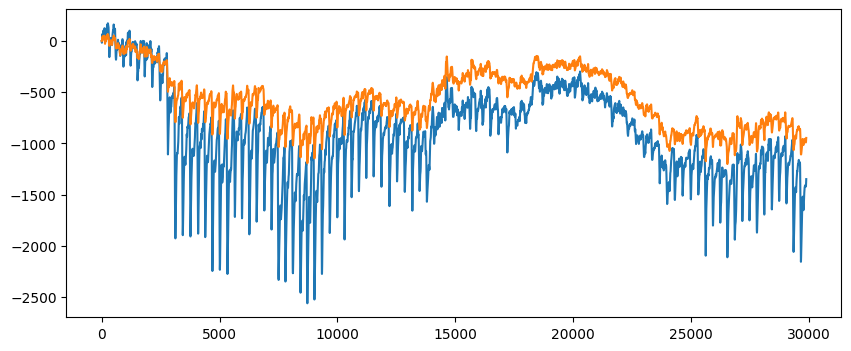

In [4]:
red_data_clean = nk.ppg_clean(red_data, method='nabian2018', sampling_rate=1000)
ir_data_clean = nk.ppg_clean(ir_data, method='nabian2018', sampling_rate=1000)
ir_data_clean = nk.ppg_clean(ir_data_clean, method='nabian2018', sampling_rate=1000)


plt.figure(figsize=(10,4))
plt.plot(red_data_clean-red_data.iloc[0,0])
plt.plot(ir_data_clean-ir_data.iloc[0,0])

Text(0, 0.5, '$EDA$')

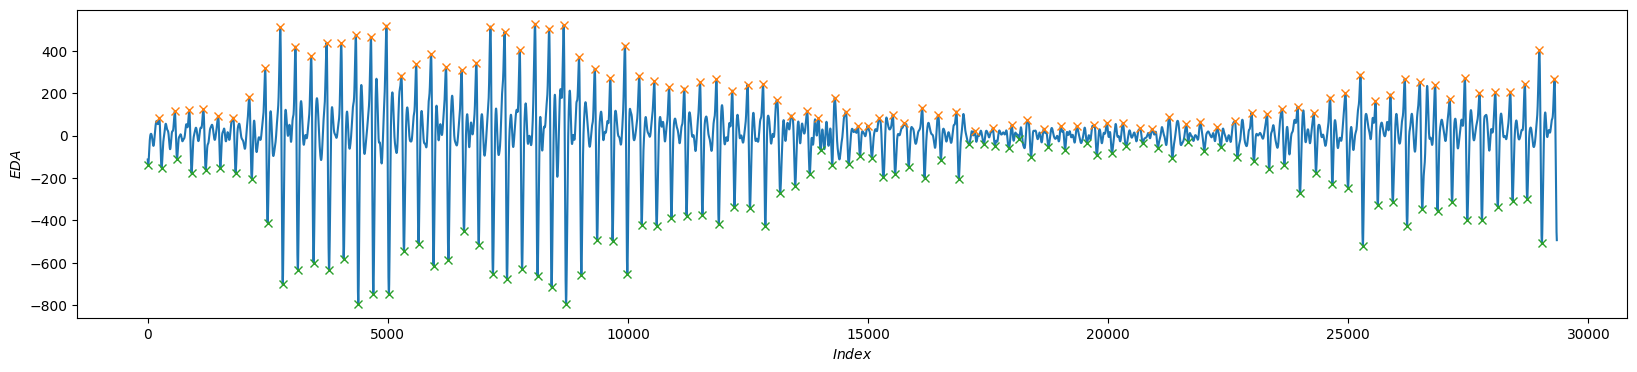

In [20]:
# Parameters 
order = 4
frequency = np.array([1,5])
#frequency = 0.5
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='band')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)[peaks_red_min[0]-10:peaks_red_min[-1]]
peaks_red, _ = find_peaks(np.array(red_filt), height=0, distance=0.5*fs)
peaks_red_min, _ = find_peaks(-red_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot((red_data-red_data.iloc[0,0]))
plt.plot(red_filt)
plt.plot(peaks_red, red_filt[peaks_red], "x")
plt.plot(peaks_red_min, red_filt[peaks_red_min], "x")
# labels and titles
plt.xlabel('$Index$') 
plt.ylabel('$EDA$') 

In [21]:
red_filt_df = pd.DataFrame(red_filt)
AC_red = red_filt[peaks_red][:] - red_filt[peaks_red_min][:]
print(np.mean(AC_red))
print(AC_red.shape)

ValueError: operands could not be broadcast together with shapes (93,) (95,) 

In [22]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
red_filt = scipy.signal.filtfilt(b, a, red_data_clean, axis=0)

DC_red = red_filt

Text(0, 0.5, '$EDA$')

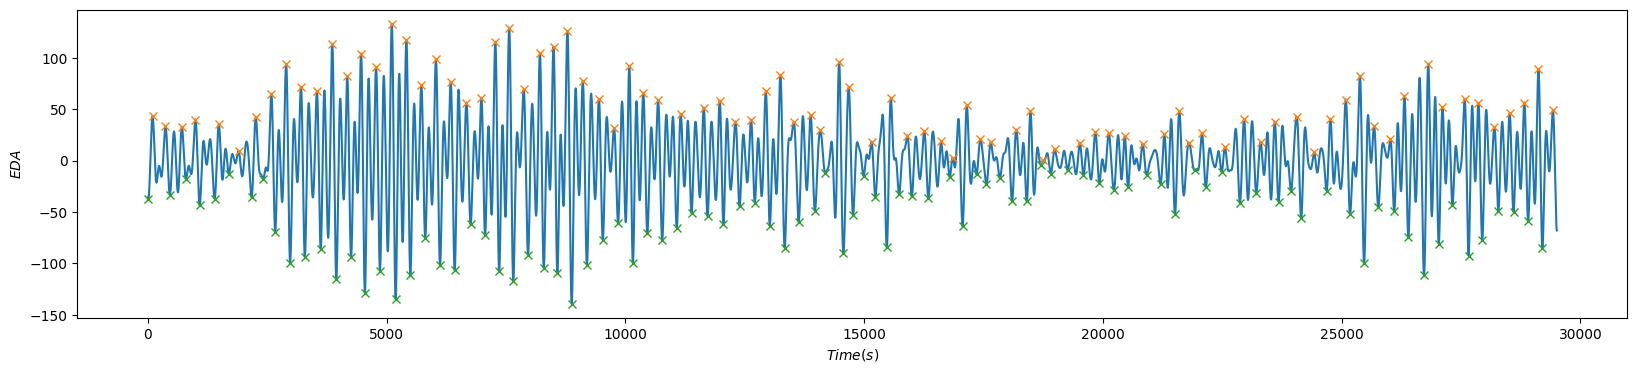

In [23]:
# Parameters 
order = 4
frequency = np.array([1,2.5])
#frequency = 0.5
sampling_rate = 300
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).

# Filtering
b, a = scipy.signal.butter(order, frequency, btype='bandpass')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

peaks_ir, _ = find_peaks(ir_filt, height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)[peaks_ir_min[0]-10:peaks_ir_min[-1]]
peaks_ir, _ = find_peaks(np.array(ir_filt), height=0, distance=0.5*fs)
peaks_ir_min, _ = find_peaks(-ir_filt, height=0, distance=0.5*fs)

# plot
plt.figure(figsize=(20,4))
#plt.plot(ir_data-ir_data.iloc[0,0])
#plt.plot(ir_filt)
plt.plot(ir_filt)
plt.plot(peaks_ir, ir_filt[peaks_ir], "x")
plt.plot(peaks_ir_min, ir_filt[peaks_ir_min], "x")
# labels and titles
plt.xlabel('$Time (s)$') 
plt.ylabel('$EDA$') 

In [78]:
AC_ir = ir_filt[peaks_ir][:] - ir_filt[peaks_ir_min][:]
print(AC_ir)

[ 69.69720793  20.14659599  60.86564872  42.1334835   14.28385748
  14.74084941  11.1498758   21.08883133  19.5204819   48.17365362
  40.48567477  12.53058235  50.64764996  40.3125072   47.6247862
  30.29597733 161.99317186 110.98952369  44.94171307  75.58744172
  51.31634062  28.49765883  33.03575383  45.98190525  43.77098549
  48.79328185  54.36798443  52.27930623  58.07880239  87.00877739]


In [79]:
# Parameters 
frequency = 0.5
frequency = frequency / (sampling_rate / 2)  # Normalize frequency to Nyquist Frequency (Fs/2).
# Filtering
b, a = scipy.signal.butter(order, frequency, btype='low')
ir_filt = scipy.signal.filtfilt(b, a, ir_data_clean, axis=0)

DC_ir = ir_filt

In [80]:
DC_mean_red_l = np.empty(0)
DC_mean_ir_l = np.empty(0)
for i in range(peaks_red_min.size):
    DC_mean_red = np.mean(DC_red[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_red_l = np.append(DC_mean_red_l, DC_mean_red)
    DC_mean_ir = np.mean(DC_ir[peaks_red_min[i]-100:peaks_red_min[i]+100])
    DC_mean_ir_l = np.append(DC_mean_ir_l, DC_mean_ir)

print(DC_mean_red_l.shape)
print(DC_mean_ir_l.shape)

(31,)
(31,)


In [85]:
R = (AC_red[:] - DC_mean_red_l[:]) / (AC_ir[:] - DC_mean_ir_l[:])
SPO2 = 104 - 17 * R

plt.plot(SPO2)

ValueError: operands could not be broadcast together with shapes (30,) (31,) 